<a href="https://www.kaggle.com/code/faressayah/amazon-reviews-sentiment-analysis-with-keras?scriptVersionId=119409183" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Text classification

This notebook shows how to do text classification starting from raw text (as a set of text files on disk). 

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the data: IMDB movie review sentiment classification

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  53.6M      0  0:00:01  0:00:01 --:--:-- 53.6M
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  aclImdb  aclImdb_v1.tar.gz


The `aclImdb` folder contains a train and test subfolder:

In [4]:
!ls aclImdb/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
README	imdb.vocab  imdbEr.txt	test  train


In [5]:
!ls aclImdb/test

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [6]:
!ls aclImdb/train

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


We are only interested on  `pos` and `neg` subfolders, so let's delete the rest:

In [7]:
!rm -r aclImdb/train/unsup

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


The `aclImdb/train/pos` and `aclImdb/test/neg` folders contain text files, each of which represents on review (either positive or negative).

In [8]:
!cat aclImdb/train/neg/5003_4.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
I'm embarrassed to be writing this review. I say that because those of you reading it will know that I sat through the whole thing and that is embarrassing to admit even to strangers. But I just had to warn those who read the viewer comments on IMDb before they watch a film not to watch this one. It's the least I can do. This is a bad movie! Trust me. The plot is goofy. The acting is amateurish. And the directing, camera work, sets, costumes, etc. are all second rate. Let it go.

In [9]:
!cat aclImdb/train/pos/4002_8.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
At the beginning of the film we watch May and Toots preparing for their trip to London for a visit to their grown children. One can see Toots is not in the best of health, but he goes along. When he dies suddenly, May's world, begins to spin out of control.<br /><br />The film directed by Roger Michell, based on a screen play by Hanif Kureshi, is a study of how this mother figure comes to terms with her new status in life and her awakening into a world that she doesn't even know it existed until now.<br /><br />May's life as a suburban wife was probably boring. Obviously her sexual life was next to nothing. We get to know she's had a short extra marital affair, then nothing at all. When May loses her husband she can't go back home, so instead, she stays behind minding her grandson at her daughter's home. It is in this setting that May begins lusting after young and hunky Darren, her daught

In [10]:
# Distribution of positive and negative reviews on train and test set

train_path = "aclImdb/train"
test_path = "aclImdb/test"

print("====================Train Set====================")
print(f"We have: {len(os.listdir(train_path+'/pos'))} positive reviews.")
print(f"We have: {len(os.listdir(train_path+'/neg'))} negative reviews.")

print("====================Test Set====================")
print(f"We have: {len(os.listdir(test_path+'/pos'))} positive reviews.")
print(f"We have: {len(os.listdir(test_path+'/neg'))} negative reviews.")

====================Train Set====================
We have: 12500 positive reviews.
We have: 12500 negative reviews.
====================Test Set====================
We have: 12500 positive reviews.
We have: 12500 negative reviews.


You can use the utility `tf.keras.preprocessing.text_dataset_from_directory` to generate a labeled `tf.data.Dataset` object from a set of text files on disk filed into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation and training datasets are generated from two subsets of the `train` directory, with 20% samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning hyperparameters, such as the model architecture, for which the test dataset should not be used.

Before putting the model out into the real world however, it should be retrained using all available training data (without creating a validation dataset), so its performance is maximized.

When using the `validation_split & subset` arguments, make sure to either specify a random seed, or set `shuffle=False`, so that the validation & training splits you get have overlap.

In [11]:
batch_size = 8
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.5,
    subset="training",
    seed=42
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size,
    validation_split=0.1,
    subset="validation",
    seed=42
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {tf.data.experimental.cardinality(raw_train_ds)}")
print(f"Number of batches in raw_val_ds: {tf.data.experimental.cardinality(raw_val_ds)}")
print(f"Number of batches in raw_test_ds: {tf.data.experimental.cardinality(raw_test_ds)}")

Found 25000 files belonging to 2 classes.
Using 12500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 1563
Number of batches in raw_val_ds: 313
Number of batches in raw_test_ds: 3125


It's important to take a look at your raw data to ensure your normalization and tokenization will work as expected. We can do that by taking a few examples from the training set and looking at them.

In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
0
b"I pity people calling kamal hassan 'ulaganaayakan' maybe for them ulagam is tollywood ! comeon guys..this movie is a thriller without thrill..<br /><br />come out of your ulagam and just watch some high class thrillers like The Usual Suspe

# Prepare the data

Having looked at our data above, we see that the raw text contains HTML break tags of the form `<br />`. These tags will not be removed by the default standardizer (which doesn't strip HTML). Because of this, we will need to create a custom standardization function.

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re


# Removing <br/>
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s] % re.escape(string.punctuation)", ""
    )

# Model constants.
max_features = 60000
embedding_dim = 512
sequence_length = 1000

Now that we have our custom standardization, we can instantiate our text vectorization layer. We are using this layer to normalize, split, and map strings to integers, so we set our `'output_mode'` to `int`. Note that we are using the default split function, and the custom standardization defined above. We also set an explicit maximum sequence length, since the CNNs later in our model won't support ragged sequences.

In [14]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Let's make a text-only dataset (no labels)
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`
vectorize_layer.adapt(text_ds)

After the vocab layer has been created, we called `adapt` on a text-only dataset to create the vocabulary. You don't have to batch, but for very large datasets this means you are not keeping spare copies of the dataset in memory.

# Two options to vectorize the data

There are 2 ways we can use our text vectorization layer:

- **Option 1: Make it part of the model,** so as to obtain a model that processes raw strings.
- **Option 2: Apply it to the text dataset** to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs.

An importance difference between the two is that option 2 enables you to do `asynchronous CPU processing and buffering` of your data when training on GPU. So if you are training the model on GPU, you probably want to go with this option to get best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw strings as input. This can be done after training.

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performace on GPU
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

# Build a model

We choose a simple 1D convnet starting with an `Embedding` layer.

In [16]:
from tensorflow.keras import layers

# An integer input for vocab indices.
inputs = tf.keras.Input(shape=(None, ), dtype="int64")

# Add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
# x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(512, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# Add a vanilla hidden layer
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model

In [17]:
epochs = 10

# Fit the model using the train and test datasets.
r = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
1563/1563 [==============================] - 38s 20ms/step - loss: 0.4990 - accuracy: 0.7421 - val_loss: 0.3225 - val_accuracy: 0.8632
Epoch 2/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.1833 - accuracy: 0.9327 - val_loss: 0.5351 - val_accuracy: 0.8352
Epoch 3/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0604 - accuracy: 0.9821 - val_loss: 0.7856 - val_accuracy: 0.8572
Epoch 4/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0439 - accuracy: 0.9866 - val_loss: 0.9249 - val_accuracy: 0.8564
Epoch 5/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0568 - accuracy: 0.9855 - val_loss: 1.0621 - val_accuracy: 0.8396
Epoch 6/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0295 - accuracy: 0.9926 - val_loss: 1.6304 - val_accuracy: 0.8396
Epoch 7/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0319 - accuracy: 0.9930 - val_loss: 1.2806 -

# Evaluate the model on the test set

In [18]:
model.evaluate(train_ds)

1563/1563 [==============================] - 7s 5ms/step - loss: 0.0065 - accuracy: 0.9994


[0.006450319197028875, 0.9994400143623352]

In [19]:
model.evaluate(val_ds)

313/313 [==============================] - 2s 5ms/step - loss: 2.5605 - accuracy: 0.8480


[2.560472249984741, 0.8479999899864197]

In [20]:
model.evaluate(test_ds)

3125/3125 [==============================] - 17s 5ms/step - loss: 2.8046 - accuracy: 0.8388


[2.804553985595703, 0.8388000130653381]

Text(0.5, 1.0, 'Loss function evolution')

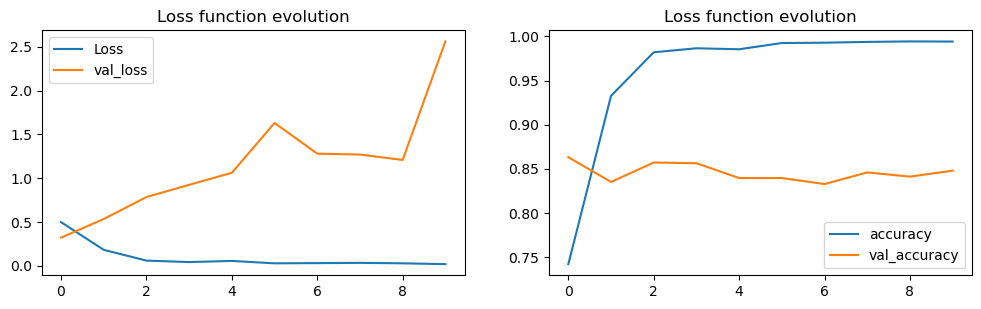

In [21]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss function evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Loss function evolution')

In [22]:
# from sklearn.metrics import confusion_matrix, classification_report

# pred = model.predict(test_ds)

# print(confusion_matrix(raw_test_ds., pred > 0.5))

# Make an end-to-end model

If you want to obtain a model capable of processing raw strings, you can simply create a new model (using the weights we just trained)

In [23]:
# A string input
inputs = tf.keras.Input(shape=(1, ), dtype="string")

# Turn strings into vocab indices
indices = vectorize_layer(inputs)

# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

3125/3125 [==============================] - 19s 6ms/step - loss: 2.8046 - accuracy: 0.8388


[2.804551362991333, 0.8388000130653381]